# Casual Bottle Anomaly Detection (Two-Stage System)

This project detects anomalies in bottle images uploaded under casual, real-world conditions.
The system uses:
1. Object detection to localize bottle(s)
2. Anomaly detection to identify and visualize defects using heatmaps

Output:
- Detected bottle bounding boxes
- Anomaly score per bottle
- Heatmap highlighting anomalous regions

-By Arkaprava Roy


In [1]:
!pip install -q ultralytics timm opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.5 MB/s eta 0:00:00


In [2]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from ultralytics import YOLO
from torchvision import models, transforms
from tqdm import tqdm

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
yolo_model = YOLO("yolov8n.pt")

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
backbone = models.resnet18(weights="IMAGENET1K_V1")
backbone = torch.nn.Sequential(*list(backbone.children())[:-2])
backbone.to(device)
backbone.eval()

In [7]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [8]:
def extract_features(image):
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        feat = backbone(image)
    return feat.squeeze(0)

In [11]:
!pip install -q kaggle

In [12]:
import os
os.environ["KAGGLE_API_TOKEN"] = "KGAT_574300132082c3cae00812e614526948"

In [13]:
import json
import os

kaggle_dict = {
    "username": "arkapravaroyit27",
    "key": "KGAT_574300132082c3cae00812e614526948"
}

os.makedirs("/root/.kaggle", exist_ok=True)

with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump(kaggle_dict, f)

!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d ipythonx/mvtec-ad
!unzip mvtec-ad.zip

In [15]:
normal_feature_bank = []

mvtec_path = "bottle/train/good"

for img_name in tqdm(sorted(os.listdir(mvtec_path))):
    img = cv2.imread(f"{mvtec_path}/{img_name}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    feat = extract_features(img)
    normal_feature_bank.append(feat)

print("Normal samples:", len(normal_feature_bank))

100%|██████████| 209/209 [00:19<00:00, 10.76it/s]

Normal samples: 209


In [16]:
def compute_anomaly_map(test_feat, memory_bank):
    dists = []
    for ref in memory_bank:
        d = torch.norm(test_feat - ref, dim=0)
        dists.append(d)
    dists = torch.stack(dists)
    return dists.min(dim=0)[0].cpu().numpy()

In [17]:
normal_scores = []

for feat in tqdm(normal_feature_bank):
    amap = compute_anomaly_map(feat, normal_feature_bank)
    normal_scores.append(amap.max())

normal_scores = np.array(normal_scores)
AUTO_THRESHOLD = np.percentile(normal_scores, 95)

AUTO_THRESHOLD

100%|██████████| 209/209 [00:02<00:00, 73.35it/s]


np.float32(0.0)

In [18]:
def compute_confidence(score, normal_scores):
    return float(np.mean(normal_scores < score) * 100)

In [19]:
def draw_anomaly_mask(image, anomaly_map, alpha=0.4):
    h, w, _ = image.shape
    amap = cv2.resize(anomaly_map, (w, h))

    amap = (amap - amap.min()) / (amap.max() - amap.min() + 1e-6)
    mask = (amap > 0.6).astype(np.uint8) * 255

    red = np.zeros_like(image)
    red[:, :, 0] = mask

    return cv2.addWeighted(red, alpha, image, 1 - alpha, 0)

In [24]:
def detect_and_analyze(image_path):
    img_bgr = cv2.imread(image_path)
    img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    results = yolo_model(image_path)
    outputs = []

    for box in results[0].boxes:
        label = yolo_model.names[int(box.cls[0])]
        if label not in ["bottle", "vase"]:
            continue

        x1, y1, x2, y2 = map(int, box.xyxy[0])
        crop = img[y1:y2, x1:x2]
        if crop.size == 0:
            continue

        feat = extract_features(crop)
        amap = compute_anomaly_map(feat, normal_feature_bank)

        score = amap.max()
        status = "ANOMALOUS" if score > AUTO_THRESHOLD else "NORMAL"
        confidence = compute_confidence(score, normal_scores)

        severity = get_severity(score, AUTO_THRESHOLD)
        coverage = defect_coverage(amap)


        heatmap = cv2.applyColorMap(
            cv2.resize((amap / amap.max() * 255).astype(np.uint8),
                       (crop.shape[1], crop.shape[0])),
            cv2.COLORMAP_JET
        )

        overlay = cv2.addWeighted(crop, 0.6, heatmap, 0.4, 0)
        overlay = draw_anomaly_mask(overlay, amap)

        outputs.append(
        (overlay, score, confidence, status, severity, coverage)
        )

    return outputs

Saving istockphoto-667819924-612x612.jpg to istockphoto-667819924-612x612 (1).jpg

image 1/1 /content/istockphoto-667819924-612x612 (1).jpg: 640x448 1 tie, 1 vase, 161.0ms
Speed: 10.7ms preprocess, 161.0ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 448)
Bottle 1
 Status     : ANOMALOUS
 Severity   : HIGH
 Score      : 60.74
 Confidence : 100.0 %
 Coverage   : 61.2 %


/tmp/ipython-input-306848932.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = score / threshold


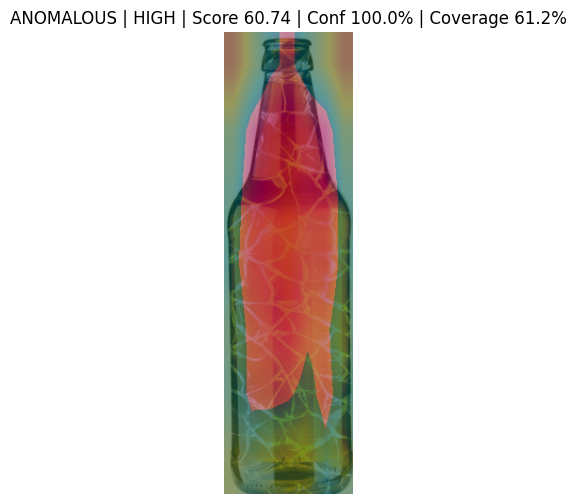

In [25]:
from google.colab import files

uploaded = files.upload()
image_path = list(uploaded.keys())[0]

results = detect_and_analyze(image_path)

for i, (img, score, conf, status, severity, coverage) in enumerate(results):

    print(f"Bottle {i+1}")
    print(" Status     :", status)
    print(" Severity   :", severity)
    print(" Score      :", round(score, 2))
    print(" Confidence :", round(conf, 1), "%")
    print(" Coverage   :", round(coverage, 1), "%")


    plt.figure(figsize=(4,6))
    plt.imshow(img)
    plt.title(
    f"{status} | {severity} | "
    f"Score {score:.2f} | "
    f"Conf {conf:.1f}% | "
    f"Coverage {coverage:.1f}%"
    )
    plt.axis("off")
    plt.show()

In [22]:
def get_severity(score, threshold):
    ratio = score / threshold
    if ratio < 1.2:
        return "LOW"
    elif ratio < 1.8:
        return "MEDIUM"
    else:
        return "HIGH"

In [23]:
def defect_coverage(anomaly_map, thresh_ratio=0.6):
    thresh = thresh_ratio * anomaly_map.max()
    mask = anomaly_map > thresh
    return float(100 * np.sum(mask) / mask.size)

In [27]:
np.save("normal_features.npy", normal_feature_bank)
np.save("normal_scores.npy", normal_scores)

In [29]:
from google.colab import files

files.download("normal_features.npy")
files.download("normal_scores.npy")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>